# Demo: Gaussian processes under multiple constraints

In this notebook, we propose a demo example of the implementation of a Gaussian process (GP) under both boundedness and monotonicity constraints. The model is constructed via the MaxMod algorithm proposed in [1]

[1] F. Bachoc, A. F. López-Lopera, and O. Roustant. *Sequential construction and dimension reduction of Gaussian
processes under inequality constraints*. 2020. URL: https://arxiv.org/abs/2009.04188.

In [1]:
# loading useful libraries
library("lineqGPR")
require("DiceDesign")
library("plot3D")
library("viridis")

rm(list=ls())
options(warn=-1)

Warning message:
"package 'lineqGPR' was built under R version 4.0.4"
Loading required package: broom

Warning message:
"package 'broom' was built under R version 4.0.4"
Loading required package: nloptr

Loading required package: purrr

Loading required package: DiceDesign

Warning message:
"package 'DiceDesign' was built under R version 4.0.4"
Loading required package: viridisLite



In [2]:
# Synthetic data: monotonic function
targetFun <- function(x) return(atan(10*x[,2])  + 0.5*x[,1])

In [3]:
D <- 2 # number of active + inactive input variables
d <- 2 # number of active input variables

# building DoE in dimension D via Latin hypercube sampling (LHS)
nbPoints <- 20*D # nb of training data
xdesign <- lhsDesign(nbPoints, D, seed = 2)$design
xdesign <- maximinSA_LHS(xdesign)$design
xdesign <- xdesign[,2:1]
ydesign <- targetFun(xdesign)

# building a DoE for assessing the model
ntest <- 10*D
xtest <- matrix(seq(0, 1, length = ntest))
xtest <- as.matrix(expand.grid(xtest, xtest))
xtest <- xtest[,2:1]
ytest <- targetFun(xtest)

In [4]:
# initializing a 1D GP model with only two knots 
model <-  create(class = 'lineqMaxModGP',
                 x = rep(0, nbPoints), y = ydesign,
                 constrType = "monotonicity")
model$localParam$m <- 2
model$uinit <- lapply(1:D, function(x) seq(0, 1, length.out = model$localParam$m))
model$varnoise <- var(ydesign)
model$kernParam$nugget <- 1e-5

In [5]:
# updating the model according to the MaxMod algorithm
max_iter <- 10
tol <- 1e-3
model <- MaxMod(model,
                xdesign,
                xtest,
                D = D,
                tol = tol,
                max_iter = max_iter,
                reward_new_knot = 1e-9,
                reward_new_dim = 1e-12,
                print_iter = TRUE,
                nClusters = 10,
                save_history = TRUE)

message("\nNumber of active dimensions: ", d)
message("Number of actived dimensions via MaxMod: ", model$d, "\n")

                    dim 1    dim 2
MaxMod criterion 1.117883 1.137835
knot's position       NaN      NaN
decision         0.000000 1.000000


Iter 1 - dimension 2 added as d = 1 (MaxMod criterion = 1.13783492566082)



                      dim 1      dim 2
MaxMod criterion 0.01119875 0.02288218
knot's position         NaN 0.33363253
decision         0.00000000 1.00000000


Iter 2 - New knot added: d = 1 (MaxMod criterion = 0.0228821834724111)



                      dim 1        dim 2
MaxMod criterion 0.01005263 0.0006342187
knot's position         NaN 0.4997498664
decision         1.00000000 0.0000000000


Iter 3 - dimension 1 added as d = 2 (MaxMod criterion = 0.0100526319133376)



                        dim 1       dim 2
MaxMod criterion 0.0003217598 0.001284826
knot's position  0.6481839812 0.124717178
decision         0.0000000000 1.000000000


Iter 4 - New knot added: d = 1 (MaxMod criterion = 0.00128482606581015)



                        dim 1        dim 2
MaxMod criterion 0.0001603492 2.136571e-05
knot's position  0.5510072273 6.314209e-01
decision         1.0000000000 0.000000e+00


Iter 5 - New knot added: d = 2 (MaxMod criterion = 0.000160349187912383)

The sequential algorithm converged


Number of active dimensions: 2

Number of actived dimensions via MaxMod: 2




In [6]:
# evaluating the model using an equispaced grid of points
ntest <- 10
xtestGrid  <- as.matrix(expand.grid(seq(0, 1, length = ntest), seq(0, 1, length = ntest)))
ytestGrid <- targetFun(xtestGrid)
pred <- predict(model, xtestGrid)

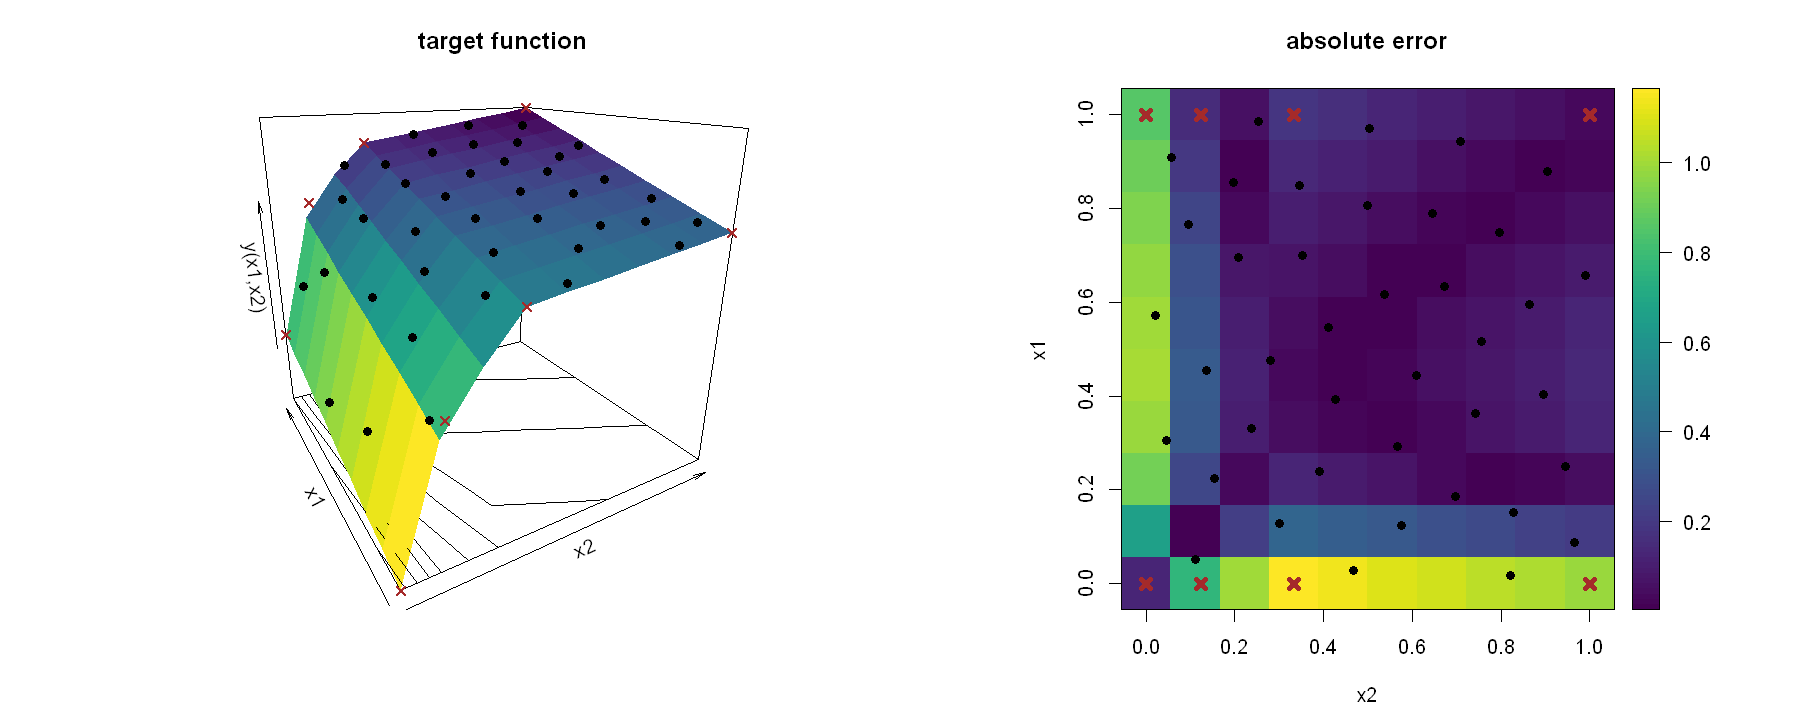

In [7]:
# plotting the MAP estimate
colormap <- rev(viridis(1e2))
par(mfrow = c(1,2))
options(repr.plot.width = 15, repr.plot.height = 6)
p <- persp3D(x = seq(0, 1, length = ntest), y = seq(0, 1, length = ntest),
             z = matrix(pred$Phi.test %*% pred$xi.map, nrow = ntest),
             xlab = "x2", ylab = "x1", zlab = "y(x1,x2)",
             main = "target function",
             phi = 20, theta = -30, col = colormap,
             contour = TRUE, colkey=FALSE)
points(trans3D(x = model$x[, 1], y = model$x[, 2], z = ydesign, pmat = p),
       col = 'black', pch = 19)
u <- expand.grid(model$u[[1]], model$u[[2]])
pred_Knots <- predict(model, as.matrix(u))
points(trans3D(x = u[, 1], y = u[, 2], z = pred_Knots$Phi.test %*% pred_Knots$xi.map, pmat = p),
       col = 'brown', pch = 4, lwd = 2)

diff = ytestGrid - pred$Phi.test %*% pred$xi.map
image2D(abs(matrix(diff, nrow = ntest)), col = rev(colormap),
        main = "absolute error", xlab = "x2", ylab = "x1")
points2D(model$x[, 1], model$x[, 2], add = TRUE, pch = 19, col ='black')
points2D(u[, 1], u[, 2], add = TRUE, pch = 4, lwd = 4, col ='brown')